In [1]:
import os
from tempfile import tempdir
from time import time
from unittest.mock import NonCallableMagicMock
import pandas as pd
import numpy as np
import warnings
import math
import re
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import seaborn as sns
warnings.filterwarnings("ignore")

import sys
sys.path.append("./")

from pathlib import Path

import tqdm
import importlib

import matplotlib.pyplot as plt
# from PySide2.QtWidgets import QFileDialog, QApplication
# from PySide2.QtCore import Qt
from copy import copy 

import pandas as pd

from corems.mass_spectra.input import rawFileReader
from corems.molecular_id.factory.classification import HeteroatomsClassification, Labels
from corems.molecular_id.search.priorityAssignment import OxygenPriorityAssignment
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.encapsulation.factory.parameters import MSParameters
from corems.encapsulation.constant import Atoms
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration

import corems.lc_icpms_ftms.calc.lc_icrms_qc_assign as icrms
import corems.lc_icpms_ftms.calc.lc_icrms_helpers as lcmsfns
import corems.lc_icpms_ftms.calc.align_icpms_esi_fns as algnfns

import importlib

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

#drive_dir = '/home/dewey/Rawfiles/spring-env/pos/test/'
drive_dir = '/Users/christiandewey/Rawfiles/spring-env/pos/test/test2/'

#rawfiledir = '/home/dewey/Rawfiles/spring-env/pos/test/'
rawfiledir = '/Users/christiandewey/Rawfiles/spring-env/pos/test/test2/'



In [3]:
def postAssignProcess(heter, results):

    ##add 'Window Size (m/z)', 'm/z window', 'Rep', 'mol_class' columns

    results = lcmsfns.add_mzwindow_col(results)                 # adds 'Window Size (m/z)' and 'm/z window' columns
    results = lcmsfns.addRepCol(results)                        # adds 'Rep' column
    molclasses = lcmsfns.get_mol_class(heter)                   # creates list of mol_classes based on heteroatom list
    results = lcmsfns.assign_mol_class(results,molclasses)      # adds 'mol_class' column 

    return results

In [6]:
#### SPRING-ENV
#### LOAD PROCESSED DATA SET FOR FIGURES 

importlib.reload(lcmsfns)

data_dir = drive_dir 

heter = ['N',  'P','S', 'Cu'] 


fname1 = '230330_spring-env_pos_1.csv'
results1 = pd.read_csv(data_dir+fname1)
results1 = postAssignProcess(heter, results1)
results1.to_csv(data_dir + 'p' + fname1)
df1 = pd.read_csv(data_dir + 'p' + fname1) 
df1['Window Size (m/z)'] = df1['Window Size (m/z)'].map(str)


fname2 = '230330_spring-env_pos_2.csv'
results2 = pd.read_csv(data_dir+fname2)
results2 = postAssignProcess(heter, results2)
results2.to_csv(data_dir + 'p' + fname2)
df2 = pd.read_csv(data_dir + 'p' + fname2) 
df2['Window Size (m/z)'] = df2['Window Size (m/z)'].map(str)



20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw
[1]

time: 10
unassigned:  35
assigned:  583
	CHO: 2
	CHON: 2
	CHONP: 2
	CHONS: 0
	CHONCu: 404
	CHOP: 28
	CHOPS: 0
	CHOPCu: 0
	CHOS: 137
	CHOSCu: 0
	CHOCu: 0
	CHONPS: 0
	CHONPCu: 0
	CHONSCu: 0
	CHONPSCu: 0
	Unassigned: 35

time: 11
unassigned:  101
assigned:  1624
	CHO: 8
	CHON: 21
	CHONP: 26
	CHONS: 107
	CHONCu: 1056
	CHOP: 62
	CHOPS: 35
	CHOPCu: 0
	CHOS: 270
	CHOSCu: 0
	CHOCu: 0
	CHONPS: 1
	CHONPCu: 0
	CHONSCu: 0
	CHONPSCu: 0
	Unassigned: 101

time: 12
unassigned:  131
assigned:  1710
	CHO: 5
	CHON: 21
	CHONP: 34
	CHONS: 112
	CHONCu: 1106
	CHOP: 71
	CHOPS: 24
	CHOPCu: 0
	CHOS: 267
	CHOSCu: 0
	CHOCu: 0
	CHONPS: 4
	CHONPCu: 0
	CHONSCu: 0
	CHONPSCu: 0
	Unassigned: 131

time: 13
unassigned:  119
assigned:  1834
	CHO: 6
	CHON: 23
	CHONP: 20
	CHONS: 134
	CHONCu: 1162
	CHOP: 58
	CHOPS: 34
	CHOPCu: 0
	CHOS: 305
	CHOSCu: 0
	CHOCu: 0
	CHONPS: 6
	CHONPCu: 0
	CHONSCu: 0
	CHONPSCu: 0
	Unassigned: 119
20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.r

In [15]:
unasgn1 = df1[df1['Molecular Formula'].isna()]  # df 1 is narrow param set first, broad param set second
print(len(unasgn1))


unasgn2 = df2[df2['Molecular Formula'].isna()]
print(len(unasgn2))

print(np.shape(results1), np.shape(results2))

386
359
(5939, 39) (6072, 38)


In [22]:
df1.sort_values(by=['m/z'], inplace = True)
df2.sort_values(by=['m/z'], inplace = True)

shared_mzs = df1['m/z'][df1['m/z'].isin(df2['m/z'])]

optimal_mfs = [] 

from_1 = []
from_2 = []
for mz in shared_mzs:
    
    r_mz_1 = df1[df1['m/z']==mz]
    mf1 = r_mz_1['Molecular Formula'].values
    err1 = r_mz_1['m/z Error (ppm)'].values

    r_mz_2 = df2[df2['m/z']==mz]
    mf2 = r_mz_2['Molecular Formula'].values
    err2 = r_mz_2['m/z Error (ppm)'].values
    
    if (mf1[0] == 'nan') and (mf2[0] == 'nan'):
        
        continue

    else:

        if np.abs(err1[0]) < np.abs(err2[0]):

            r_mz_1['param_set'] = 1

            optimal_mfs.append(r_mz_1)

        elif np.abs(err2[0]) < np.abs(err1[0]):

            r_mz_2['param_set'] = 2

            optimal_mfs.append(r_mz_2)

        elif np.abs(err2[0]) == np.abs(err1[0]):

            r_mz_2['param_set'] = 0

            optimal_mfs.append(r_mz_2)


optimal_mfs_pd = pd.concat(optimal_mfs)

print(np.shape(optimal_mfs_pd))

(5542, 41)


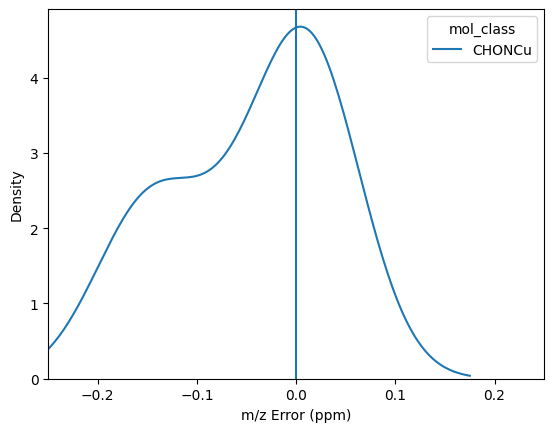

In [45]:
fig, ax = plt.subplots()

t = optimal_mfs_pd[(optimal_mfs_pd['param_set'] == 1) ]

t = t[(t['Cu'] > 0) & (t['N'] <7 )]
#t = optimal_mfs_pd[(optimal_mfs_pd['N'] > 0)]

sns.kdeplot(data = t, x = 'm/z Error (ppm)', hue = 'mol_class',ax = ax, palette=['C0', 'C1'])
#sns.kdeplot(data = t, x = 'm/z Error (ppm)', hue = 'N',ax = ax)

ax.set_xlim(-.25,.25)

ax.axvline(0)
plt.show()

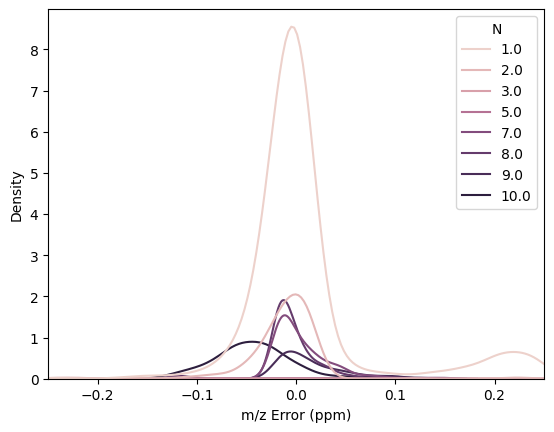

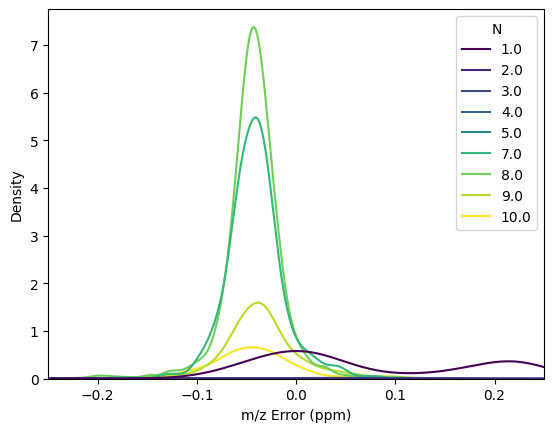

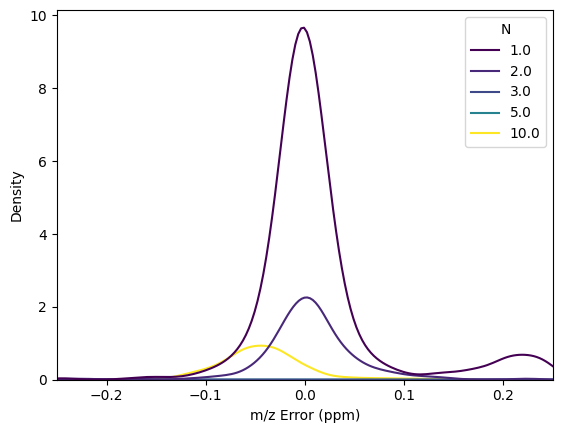

In [18]:
fig, ax = plt.subplots()

t = optimal_mfs_pd[(optimal_mfs_pd['N'] >0)]

#sns.kdeplot(data = t, x = 'm/z Error (ppm)', hue = 'mol_class',ax = ax, palette=['C0', 'C1'])
sns.kdeplot(data = t, x = 'm/z Error (ppm)', hue = 'N',ax = ax)
ax.set_xlim(-.25, .25)
plt.show()


fig, ax = plt.subplots()


t = df1[(df1['N'] > 0) ]

sns.kdeplot(data = t, x = 'm/z Error (ppm)', hue = 'N',ax = ax, palette='viridis')
ax.set_xlim(-.25, .25)
plt.show()



fig, ax = plt.subplots()


t = df2[(df2['N'] > 0) ]

#sns.kdeplot(data = t, x = 'm/z Error (ppm)', hue = 'mol_class',ax = ax, palette=['C4', 'C5'])
sns.kdeplot(data = t, x = 'm/z Error (ppm)', hue = 'N',ax = ax, palette='viridis')
ax.set_xlim(-.25, .25)

plt.show()

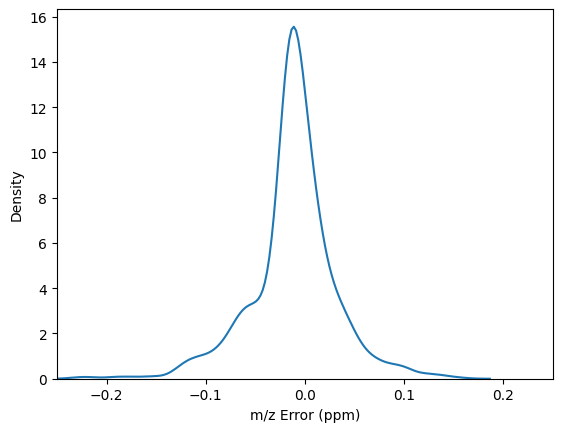

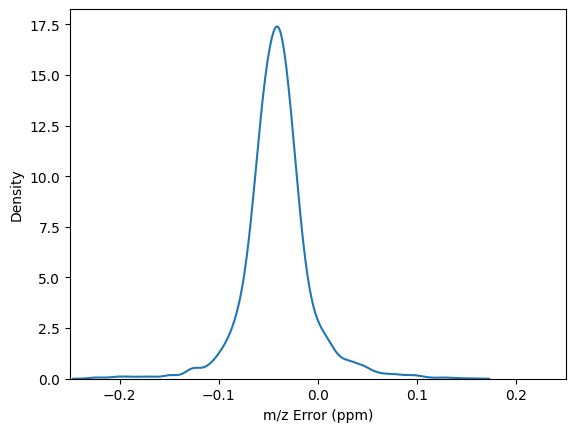

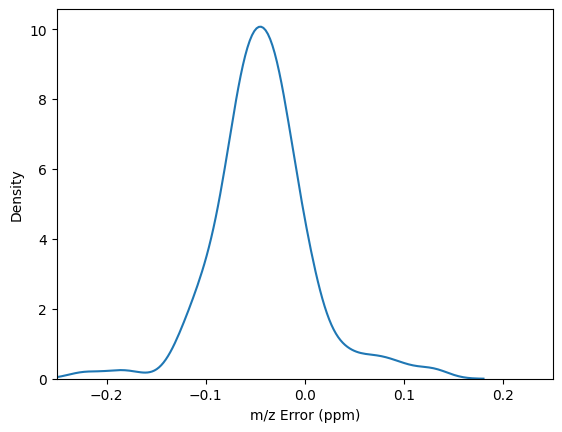

In [19]:
fig, ax = plt.subplots()

el = 'Cu'
t = optimal_mfs_pd[(optimal_mfs_pd[el] > 0) & (optimal_mfs_pd['N']>=0)]

#sns.kdeplot(data = t, x = 'm/z Error (ppm)', hue = 'mol_class',ax = ax, palette=['C0', 'C1'])
sns.kdeplot(data = t, x = 'm/z Error (ppm)', ax = ax)
ax.set_xlim(-.25, .25)

plt.show()


fig, ax = plt.subplots()


t = df1[(df1[el] > 0) ]

sns.kdeplot(data = t, x = 'm/z Error (ppm)', ax = ax, palette='viridis')
ax.set_xlim(-.25, .25)

plt.show()



fig, ax = plt.subplots()


t = df2[(df2[el] > 0) ]

#sns.kdeplot(data = t, x = 'm/z Error (ppm)', hue = 'mol_class',ax = ax, palette=['C4', 'C5'])
sns.kdeplot(data = t, x = 'm/z Error (ppm)', ax = ax, palette='rocket')

ax.set_xlim(-.25, .25)
plt.show()

In [23]:
cu_opt = optimal_mfs_pd[optimal_mfs_pd['Cu']>0]

cu_opt

,Unnamed: 0,Unnamed: 0.1,Index,m/z,Calibrated m/z,Calculated m/z,Peak Height,Peak Area,Resolving Power,S/N,...,Time,18O,file,m/z window,Window Size (m/z),Rep,ID,mol_class,param_set,65Cu
2469,2344,2344,1,400.139078,400.139095,400.139096,15215.436423,-9.456054,826689.247675,15.825540,...,12,NaN,20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw,400-500 m/z,100,1,2344,CHONCu,1,NaN
4255,4185,4185,1,400.139094,400.139091,400.139096,13369.242974,-7.997767,620016.626427,14.073570,...,13,NaN,20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw,400-500 m/z,100,1,4185,CHONCu,1,NaN
1772,621,621,5,400.150302,400.150313,400.150330,6845.750385,-4.045560,826665.835441,5.439746,...,11,NaN,20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw,400-500 m/z,100,1,621,CHONCu,0,NaN
3560,2343,2343,5,400.150307,400.150324,400.150330,4963.817150,-3.217511,619999.685937,5.162855,...,12,NaN,20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw,400-500 m/z,100,1,2343,CHONCu,0,NaN
5468,4172,4172,5,400.150333,400.150330,400.150330,2880.577204,-1.800550,826665.835732,3.032334,...,13,NaN,20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw,400-500 m/z,100,1,4172,CHONCu,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1824,2237,2237,1715,499.228738,499.228649,499.228640,4237.638952,-3.507507,496952.626673,3.367298,...,11,NaN,20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw,400-500 m/z,100,1,2237,CHONCu,1,NaN
3571,4048,4048,1822,499.228775,499.228688,499.228640,3000.704789,-2.323269,496952.686369,3.121026,...,12,NaN,20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw,400-500 m/z,100,1,4048,CHONCu,1,NaN
5404,6001,6001,1937,499.236864,499.236740,499.236745,18941.915718,-18.642353,662592.502277,19.939826,...,13,NaN,20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw,400-500 m/z,100,1,6001,CHONCu,1,NaN
5414,6014,6014,1938,499.244071,499.243947,499.243896,2856.207583,-3.027925,496937.376688,3.006680,...,13,NaN,20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw,400-500 m/z,100,1,6014,CHONCu,1,NaN


In [24]:
optimal_mfs_pd.to_csv(rawfiledir +'optimtal_cu.csv')